# **Finding Lane Lines on the Road** 
***
---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


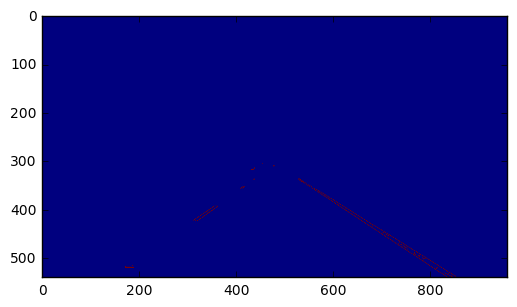

In [127]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(process_image(image))  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [1]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def convert_to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def apply_threshold(img):
    min_white, max_white = np.array([0,0,200]), np.array([255,80,255])
    min_yellow, max_yellow = np.array([65,80,80]), np.array([105,255,255])
    
    mask_white = cv2.inRange(img, min_white, max_white)
    mask_yellow = cv2.inRange(img, min_yellow, max_yellow)
    
    # Bitwise
    return cv2.bitwise_and(img, img, mask = cv2.bitwise_or(mask_white, mask_yellow))

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Init empty arrays
    xLeft, xRight, yLeft, yRight, slopeLeft, slopeRight = [[] for _ in range(6)]
    
    # Consider the image dimensions as extreme's
    yMin, yMax = int(img.shape[0]/2 + 50), img.shape[1]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if y1 < yMin:
                yMin = y1 # Compare the y with yMin; if less assign it to yMin
            
            slope = (y2 - y1) / (x2 - x1)
            
            # Filter the slopes for better results
            if  -0.9 < slope < -0.5:
                slopeLeft.append(slope)
                xLeft.append(x1)
                xLeft.append(x2)
                yLeft.append(y1)
                yLeft.append(y2)
            elif 0.2 < slope < 0.7 :
                slopeRight.append(slope)
                xRight.append(x1)
                xRight.append(x2)
                yRight.append(y1)
                yRight.append(y2)
    
    # Filtering out of bound values            
    if len(xLeft) <= 1 or len(xRight) <= 1:
        return
    
    # Calculate Averages Left Side
    slopeLeftAvg = np.mean(np.array(slopeLeft))
    xLeftAvg = np.mean(np.array(xLeft))
    yLeftAvg = np.mean(np.array(yLeft))
    
    # Calculate Averages Right Side
    slopeRightAvg = np.mean(np.array(slopeRight))
    xRightAvg = np.mean(np.array(xRight))
    yRightAvg = np.mean(np.array(yRight))
    
    # Calcuate Lef and Right Intercepts
    rightIntercept = yRightAvg - (slopeRightAvg * xRightAvg)
    leftIntercept = yLeftAvg - (slopeLeftAvg * xLeftAvg)
    
    # Calculate x Right Values
    x1_right = (yMin - rightIntercept) / slopeRightAvg
    x2_right = (yMax - rightIntercept) / slopeRightAvg
    
    # Draw Right Line
    cv2.line(img, (int(x1_right), yMin), (int(x2_right), yMax), color, thickness)
    
    # Calculate x Left Values
    x1_left = (yMin - leftIntercept)/slopeLeftAvg
    x2_left = (yMax - leftIntercept)/slopeLeftAvg
    
    # Draw Left Line
    cv2.line(img, (int(x1_left), yMin), (int(x2_left), yMax), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [366]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [367]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [368]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    y_size, x_size, color = image.shape
    
    # Convert to HSV for best image processing
    hsv_image = convert_to_hsv(image)
    
    # Remove noise with Gaussian Blur with Kernal size 3
    blur_image = gaussian_blur(hsv_image, 3)
    
    # Apply color threshold to filter unwanted colors
    threshold_image = apply_threshold(blur_image)
    
    # Apply Canny alogirthm
    canny_image = canny(threshold_image, 50, 150)
    
    # Focus on region required
    vertices = np.array([[(40, y_size), (x_size / 2, y_size / 2 + 40), (x_size / 2, y_size / 2 + 40), (x_size - 40, y_size)]], dtype=np.int32)
    cropped_image = region_of_interest(canny_image, vertices)
    
    # Apply Hough to find lines in the image
    hough_image = hough_lines(cropped_image, 1, np.pi / 180, 30, 70, 100)
    
    # Weight Image
    weight_image = weighted_img(hough_image, image, β=250)
    
    return weight_image

Let's try the one with the solid white lane on the right first ...

In [375]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 69.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 5.02 s, sys: 1.14 s, total: 6.16 s
Wall time: 3.52 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [376]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [377]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:12<00:00, 56.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 17.7 s, sys: 3.98 s, total: 21.6 s
Wall time: 12.4 s


In [378]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [373]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:08<00:00, 29.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 12.7 s, sys: 2.54 s, total: 15.3 s
Wall time: 9.75 s


In [374]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))